In [1]:
from modules import datasets
from modules import models

from keras.backend import set_epsilon
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import argparse
import locale
import os
import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
run_id='010'
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True,
#    help="path to input dataset of house images")
#args = vars(ap.parse_args())

inputPath = 'SAG3.csv'


# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading halo attributes...")
#inputPath = os.path.sep.join([args["dataset"], "HousesInfo.txt"])
df = datasets.load_halo_attributes(inputPath)
 
# construct a training and testing split with 75% of the data used
# for training and the remaining 25% for evaluation
print("[INFO] constructing training/testing split...")
(train, test) = train_test_split(df, test_size=0.25, random_state=42)

[INFO] loading halo attributes...
[INFO] constructing training/testing split...


In [3]:
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together
print("[INFO] processing data...")
(trainX, testX, trainY, testY, cs2) = datasets.process_halo_attributes_cont(df, train, test)

[INFO] processing data...


In [4]:
# create our MLP and then compile the model using mean absolute
# percentage error as our loss, implying that we seek to minimize
# the absolute percentage difference between our price *predictions*
# and the *actual prices*

model = models.create_mlp(trainX.shape[1]) ##quité el regress del ejemplo porque si o si haremos regresiones
opt = Adam(lr=1e-3, decay=1e-3 / 200)
set_epsilon(1)

  
from keras.metrics import accuracy    
    
model.compile(loss="mse", optimizer=opt, metrics = ['mape', 'mse'])
 
# train the model
print("[INFO] training model...")
history = model.fit(trainX, trainY, validation_data=(testX, testY),
    epochs=200, batch_size=20)

print('model trained')

[INFO] training model...
Train on 7500 samples, validate on 2500 samples
Epoch 1/200
7500/7500 [==============================] - 4s 584us/step - loss: 0.0247 - mape: 10.4701 - mse: 0.0247 - val_loss: 0.0066 - val_mape: 6.5431 - val_mse: 0.0066
Epoch 2/200
7500/7500 [==============================] - 1s 157us/step - loss: 0.0062 - mape: 6.3394 - mse: 0.0062 - val_loss: 0.0064 - val_mape: 6.3892 - val_mse: 0.0064
Epoch 3/200
7500/7500 [==============================] - 1s 157us/step - loss: 0.0061 - mape: 6.2139 - mse: 0.0061 - val_loss: 0.0062 - val_mape: 6.2885 - val_mse: 0.0062
Epoch 4/200
7500/7500 [==============================] - 1s 160us/step - loss: 0.0059 - mape: 6.1078 - mse: 0.0059 - val_loss: 0.0059 - val_mape: 6.1486 - val_mse: 0.0059
Epoch 5/200
7500/7500 [==============================] - 1s 156us/step - loss: 0.0056 - mape: 5.9835 - mse: 0.0056 - val_loss: 0.0055 - val_mape: 5.9132 - val_mse: 0.0055
Epoch 6/200
7500/7500 [==============================] - 1s 145us/step 

KeyboardInterrupt: 

In [5]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(testX)

preds = cs2.inverse_transform(preds)
testY = cs2.inverse_transform(testY)

np.savetxt('outputs_cont/preds_n%s.csv'%(run_id), preds, delimiter=",")
np.savetxt('outputs_cont/testY_n%s.csv'%(run_id), testY, delimiter=",")
np.savetxt('outputs_cont/mape_n%s.csv'%(run_id), history.history['mape'], delimiter=",")
np.savetxt('outputs_cont/loss_n%s.csv'%(run_id), history.history['loss'], delimiter=",")
np.savetxt('outputs_cont/mse_n%s.csv'%(run_id), history.history['mse'], delimiter=",")

mape = history.history['mape']
loss = history.history['loss']
mse = history.history['mse']

[INFO] predicting house prices...


[[6.665276]
 [8.573316]
 [7.906038]
 ...
 [6.958114]
 [8.531598]
 [6.156455]]


(array([1663.,  584.,  163.,   51.,   22.,    7.,    2.,    3.,    3.,
           2.]),
 array([2.70020387e-04, 2.70131709e-01, 5.39993397e-01, 8.09855086e-01,
        1.07971677e+00, 1.34957846e+00, 1.61944015e+00, 1.88930184e+00,
        2.15916353e+00, 2.42902522e+00, 2.69888691e+00]),
 <a list of 10 Patch objects>)

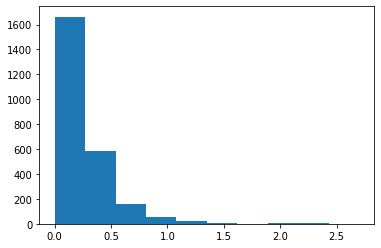

In [6]:
diffs = []



print(preds)
for i in range(len(preds)):
    diffs.append(preds[i] - testY[i])
    #print ('%d, %d'%(preds[i].argmax(), testY[i].argmax()))
diffs= np.array(np.abs(diffs))

plt.hist(diffs)

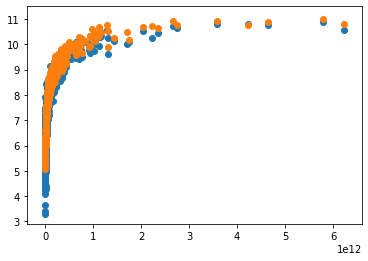

In [13]:
plt.scatter(test.HaloMass, testY)
plt.scatter(test.HaloMass, preds)

In [15]:
np.savetxt('outputs_cont/halo_masses_test.csv', np.array(test.HaloMass), delimiter=",")
